In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import cv2
import numpy as np
import glob
import csv

In [ ]:
def r_c(hist ):
    Ng = 255
    tc = 255
    index = 0
    while index <= tc and index <= Ng:
        bck_sum = 0
        hist_sum_bck = 0
        fr_sum = 0
        hist_sum_fr = 0
        b = 0 
        f = 0               
        for i in range(0, index+1):
            bck_sum += i * hist[i][0]
            hist_sum_bck += hist[i][0]            
        for j in range(index+1, Ng+1):
            fr_sum += j * hist[j][0]
            hist_sum_fr += hist[j][0]
        try:
            b = (bck_sum / hist_sum_bck)   
            f = (fr_sum / hist_sum_fr)        
            if hist_sum_bck == 0.0 : 
                raise ZeroDivisionError  
            if hist_sum_fr == 0.0:
                raise ZeroDivisionError 
        except ZeroDivisionError:
            index += 1
            continue
        tc = (b  + f) // 2 
        index += 1        
    return tc


In [ ]:
def excGrnApp(b, g, r, pmin, pmax):
    row, col = g.shape
    Eg = np.zeros([row, col], np.uint8 )    
    for i in range(0, row):
        for j in range(0, col):
            try:
                d = (2*g[i][j] - r[i][j] - b[i][j])//(g[i][j] + r[i][j] + b[i][j])
            except:
                d = 0
            try:                
                d = int((d - pmin) * 255 //( pmax - pmin))
            except:
                d = 0                
            Eg[i][j] = d            
    return Eg

In [ ]:
def regionfill(img):
    contour, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    Ar = 0    
    for cnt in contour:
        cv2.drawContours(img, [cnt],0,255,-1)
        Ar += cv2.contourArea(cnt)     
    return img, Ar

In [ ]:
def lloret(b, g, r, img):
    row, col = b.shape
    z = np.zeros([row, col], np.uint8)
    for i in range(0, row):
        for j in range(0, col):
            if g[i][j] > b[i][j] and  g[i][j] > r[i][j]:
                z[i][j] = g[i][j]         
    _, thresh = cv2.threshold(z, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh


In [ ]:
def calArea(img):
    contour, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    Ar = 0
    for cnt in contour:
        Ar += cv2.contourArea(cnt) 
    return Ar

In [ ]:
def leafNDisArea(img):
    b, g, r = cv2.split(img)
    gray_grn = excGrnApp(b, g, r, -1, 2)
    hist = cv2.calcHist([gray_grn],[0],None,[256],[0,256])
    thr = int(r_c(hist))
    _, bin_img = cv2.threshold(gray_grn, thr, 255, cv2.THRESH_BINARY)
    bin_img = cv2.medianBlur(bin_img, 3)
    bin_img, AT = regionfill(bin_img)
    grn_area = lloret(b, g, r, img.copy())
    AU = calArea(grn_area)
    per_inf = round(((AT - AU) * 100 / AT), 3)
    return AT, AT-AU, per_inf

In [ ]:
def calcSeverity(score):
    if int(score) >= 70:
        letter = 'High Severity'
    elif int(score) >= 40:
        letter = 'Medium Severity'
    else:
        letter = 'Low Severity'
    return letter

In [ ]:
def findLabel(img):   
    with open('/content/drive/My Drive/Severity/cassava_leaf/train.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if(row['image_id']==img):
                name= row['label']
    return name   

In [ ]:
def findClass(label):
    if int(label)==0:
        className = 'Cassava Bacterial Blight (CBB)'
    elif int(label) == 1:
        className = 'Cassava Brown Streak Disease (CBSD)'
    elif int(label) == 2:
        className = 'Cassava Green Mottle (CGM)'    
    else:
        className= 'Cassava Mosaic Disease (CMD)'
    return className

In [ ]:
def sugFertz(clsName):
    if clsName=='Cassava Bacterial Blight (CBB)':
        fertz = '2:4:D Ammine Salt 58% S.L, With Green Beauveria (Liquid Bio-Pesticide)'
    elif clsName == 'Cassava Brown Streak Disease (CBSD)':
        fertz = 'NPK 17:17:17 + KCl'
    elif clsName == 'Cassava Green Mottle (CGM)' :
        fertz = 'N2:P2O5:K2O:S- 60 kg N, 10-20 kg P2O5, and 50 kg K2O ha-1'    
    else:
        fertz= '4.5, 0.83 and 6.6 kg mineral N, P and K'
    return fertz

In [ ]:
local_download_path='/content/drive/My Drive/Severity/cassava_leaf/train_images'
images = glob.glob(local_download_path + '/*.jpg')
print(["File Name", "Class Name", "Class Label","Total Area","Infected Area","Infection(%)","Severity","Fertilizer"])
for filename in images:
    leaf = cv2.imread(filename)  
    AT, AI,P = leafNDisArea(leaf)
    severity = calcSeverity(P)
    value = filename.split('/')
    imgName = value[7]
    classLabel = findLabel(imgName)
    className = findClass(classLabel)
    fertilizer = sugFertz(className)
    print([str(imgName),str(className),str(classLabel),str(AT),str(AI),str(P),str(severity),str(fertilizer)])


['File Name', 'Class Name', 'Class Label', 'Total Area', 'Infected Area', 'Infection(%)', 'Severity', 'Fertilizer']
['1000015157.jpg', 'Cassava Bacterial Blight (CBB)', '0', '423874.5', '151615.0', '35.769', 'Low Severity', '2:4:D Ammine Salt 58% S.L, With Green Beauveria (Liquid Bio-Pesticide)']
['1000201771.jpg', 'Cassava Mosaic Disease (CMD)', '3', '333276.0', '104896.5', '31.474', 'Low Severity', '4.5, 0.83 and 6.6 kg mineral N, P and K']
['1000812911.jpg', 'Cassava Mosaic Disease (CMD)', '3', '399536.5', '103270.0', '25.847', 'Low Severity', '4.5, 0.83 and 6.6 kg mineral N, P and K']
['1001742395.jpg', 'Cassava Mosaic Disease (CMD)', '3', '424125.0', '78887.5', '18.6', 'Low Severity', '4.5, 0.83 and 6.6 kg mineral N, P and K']
['1000837476.jpg', 'Cassava Mosaic Disease (CMD)', '3', '456076.5', '214887.0', '47.116', 'Medium Severity', '4.5, 0.83 and 6.6 kg mineral N, P and K']
['1001749118.jpg', 'Cassava Mosaic Disease (CMD)', '3', '478298.0', '49723.5', '10.396', 'Low Severity', '

Saving 1011909285.jpg to 1011909285.jpg
-----------------------------------
SEVERITY ESTIMATION OF CASSAVA LEAF
-----------------------------------
IMAGE NAME     :  1011909285.jpg
CLASS NAME     :  Healthy
CLASS LABEL    :  4
TOTAL AREA     :  439839.5
INFECTED AREA  : NIL
INFECTED (%)   : 0%
SEVERITY       : ALL STABLE
FERTILIZER     :  Organic Manure


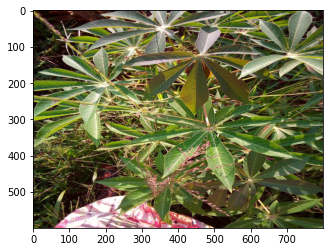

In [ ]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")
from PIL import Image
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))
local_download_path='/content/drive/My Drive/pattern/train_images'
images = local_download_path + '/' + filename
value = images.split('/')
imgName = value[6]
leaf = cv2.imread(images)  
AT, AI,P = leafNDisArea(leaf)
severity = calcSeverity(P)
classLabel = findLabel(imgName)
if classLabel=='4':

    className= "Healthy"
    fertilizer="Organic Manure"
    print("-----------------------------------")
    print("SEVERITY ESTIMATION OF CASSAVA LEAF")
    print("-----------------------------------")
    print("IMAGE NAME     : ",str(imgName))
    print("CLASS NAME     : ",str(className))
    print("CLASS LABEL    : ",str(classLabel))
    print("TOTAL AREA     : ",str(AT))
    print("INFECTED AREA  : NIL")
    print("INFECTED (%)   : 0%")
    print("SEVERITY       : ALL STABLE")
    print("FERTILIZER     :",str(fertilizer))
    img = mpimg.imread(images)
    imgplot = plt.imshow(img)
    plt.show()
    

else:
    className = findClass(classLabel)
    fertilizer = sugFertz(className)
    print("-----------------------------------")
    print("SEVERITY ESTIMATION OF CASSAVA LEAF")
    print("-----------------------------------")
    print("IMAGE NAME     : ",str(imgName))
    print("CLASS NAME     : ",str(className))
    print("CLASS LABEL    : ",str(classLabel))
    print("TOTAL AREA     : ",str(AT))
    print("INFECTED AREA  : ",str(AI))
    print("INFECTED (%)   : ",str(P))
    print("SEVERITY       : ",str(severity))
    print("FERTILIZER     : ",str(fertilizer))
    img = mpimg.imread('/content/drive/My Drive/pattern/train_images'+'/'+filename)
    imgplot = plt.imshow(img)
    plt.show()
